## Plotting of profile results

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import math
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..',  '..'))

# teslakit
from teslakit.database import Database, hyswan_db

# interactive widgets
from ipywidgets import interact, interact_manual, interactive, HBox, Layout, VBox
from ipywidgets import widgets
from natsort import natsorted, ns
from moviepy.editor import *
from IPython.display import display, Image, Video

sys.path.insert(0, op.join(os.getcwd(),'..'))

# bluemath swash module (bluemath.DD.swash

path_swash='/media/administrador/HD/Dropbox/Guam/wrapswash-1d'
sys.path.append(path_swash)
from lib.wrap import SwashProject, SwashWrap
from lib.plots import SwashPlot
from lib.io import SwashIO
from  lib.MDA import *
from lib.RBF import *


In [2]:
def Plot_profile(profile):
    colors=['royalblue','crimson','gold','darkmagenta','darkgreen','darkorange','mediumpurple','coral','pink','lightgreen','darkgreen','darkorange']
    fig=plt.figure(figsize=[17,4])
    gs1=gridspec.GridSpec(1,1)
    ax=fig.add_subplot(gs1[0])

    ax.plot(profile.Distance_profile, -profile.Elevation,linewidth=3,color=colors[prf],alpha=0.7,label='Profile: ' + str(prf))
    s=np.where(profile.Elevation<0)[0][0]
    ax.plot(profile.Distance_profile[s],-profile.Elevation[s],'s',color=colors[prf],markersize=10)
    s=np.argmin(profile.Elevation.values)
    ax.plot(profile.Distance_profile[s],-profile.Elevation[s],'d',color=colors[prf],markersize=10)
    ax.plot([0,1500],[0,0],':',color='plum',alpha=0.7)
    
    ax.set_xlabel(r'Distance (m)', fontsize=14)
    ax.set_ylabel(r'Elevation (m)', fontsize=14)
    ax.legend()
    ax.set_xlim([0,np.nanmax(profile.Distance_profile)])
    ax.set_ylim(-profile.Elevation[0], -np.nanmin(profile.Elevation)+3)
    
def get_bearing(lat1,lon1,lat2,lon2):
    dLon = np.deg2rad(lon2) - np.deg2rad(lon1);
    y = math.sin(dLon) * math.cos(np.deg2rad(lat2));
    x = math.cos(np.deg2rad(lat1))*math.sin(np.deg2rad(lat2)) - math.sin(np.deg2rad(lat1))*math.cos(np.deg2rad(lat2))*math.cos(dLon);
    brng = np.rad2deg(math.atan2(y, x));
    if brng < 0: brng+= 360
    return brng

In [3]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('GUAM')

#Define profile to run
prf=11
# sl=0 #Sea level

In [4]:
p_out = os.path.join(p_data, 'sites', 'GUAM','HYSWASH')
if not os.path.exists(p_out):   os.mkdir(p_out)

p_dataset = op.join(p_out, 'dataset_prf'+str(prf)+'.pkl')
p_subset = op.join(p_out, 'subset_prf'+str(prf)+'.pkl')
p_waves = op.join(p_out, 'waves_prf'+str(prf)+'.pkl')
ds_output = op.join(p_out, 'reconstruction_p{0}.nc'.format(prf))


In [5]:
# Create the project directory 
p_proj = op.join(p_out, 'projects')     # swash projects main directory
n_proj = 'Guam_prf_{0}'.format(prf)      # project name

sp = SwashProject(p_proj, n_proj)
sw = SwashWrap(sp)
si = SwashIO(sp)
sm = SwashPlot(sp)

### Set profile and load data

<xarray.Dataset>
Dimensions:             (number_points: 417)
Coordinates:
    profile             int64 11
  * number_points       (number_points) int64 0 1 2 3 4 ... 412 413 414 415 416
Data variables:
    Lon                 (number_points) float64 144.7 144.7 ... 144.7 144.7
    Lat                 (number_points) float64 13.47 13.47 ... 13.47 13.47
    Elevation           (number_points) float64 19.91 19.66 ... -1.259 -1.251
    Distance_profile    (number_points) float64 0.0 0.7798 1.56 ... 323.6 324.4
    Rep_coast_distance  int64 ...
    Orientation         float64 353.5


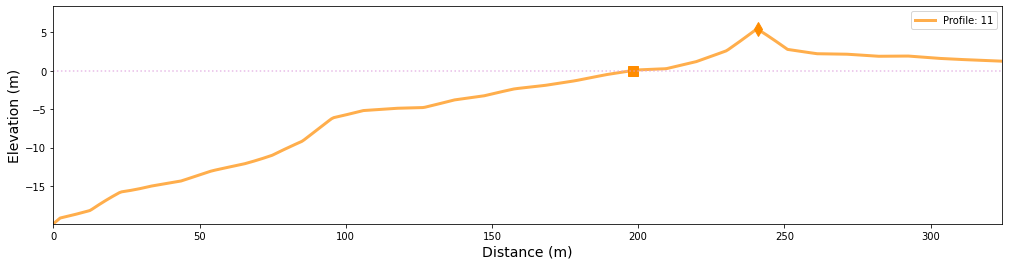

In [6]:
min_depth=-20

profiles=xr.open_dataset('/media/administrador/HD/Dropbox/Guam/bati guam/Profiles_Guam_curt.nc')
profile=profiles.sel(profile=prf)
profile['Orientation']=get_bearing(profile.Lat[0],profile.Lon[0],profile.Lat[-1],profile.Lon[-1])
s=np.where(profile.Elevation>min_depth)[0]
profile = xr.Dataset({'Lon': (['number_points'],np.flipud(profile.Lon[s])),
                          'Lat': (['number_points'],np.flipud(profile.Lat[s])),
                          'Elevation': (['number_points'],-np.flipud(profile.Elevation[s])),
                          'Distance_profile': (['number_points'],(profile.Distance_profile[s])),
                          'Rep_coast_distance': (profile.Rep_coast_distance),
                          'Orientation': (profile.Orientation),
                          }, 
                        coords={'number_points': range(len(s)), 
                              })
print(profile)
Plot_profile(profile)


### Cut profile after maximum

<xarray.Dataset>
Dimensions:             (number_points: 327)
Coordinates:
    profile             int64 11
  * number_points       (number_points) int64 0 1 2 3 4 ... 322 323 324 325 326
Data variables:
    Lon                 (number_points) float64 144.7 144.7 ... 144.7 144.7
    Lat                 (number_points) float64 13.47 13.47 ... 13.47 13.47
    Elevation           (number_points) float64 19.91 19.66 ... -2.648 -2.603
    Distance_profile    (number_points) float64 0.0 0.7798 1.56 ... 253.4 254.2
    Rep_coast_distance  int64 ...
    Orientation         float64 353.5


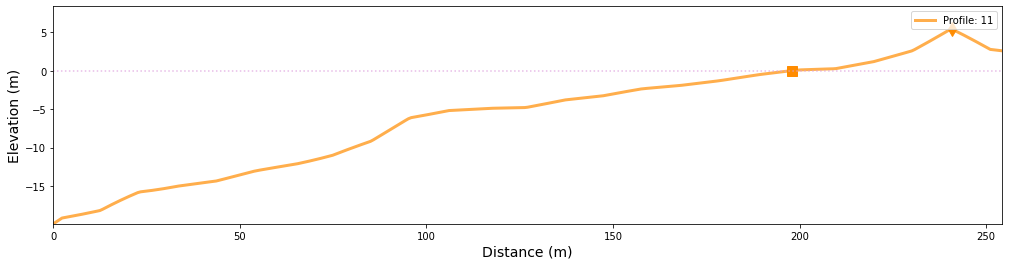

In [7]:
extra_positions=[25,28,7,25,-30,-9,-10,15,-22,12,20,18] #Cut profile at maximum + extra_positions

s=np.argmin(profile.Elevation.values)
profile=profile.isel(number_points=range(s+extra_positions[prf]))
print(profile)
Plot_profile(profile)
profile.to_netcdf(path=os.path.join(p_out,'Prf_'+str(prf)+'.nc'))

### Load waves

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
In the following cell, the input paths are defined. The user must specified the path to the hydraulic boundary conditions, considering the wind forcing and sea conditions. For simplicity, those files must be in NetCDF format. </span>

* `profile`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> : profile id </span><br>

* `sl`: <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">  sea level (sl) with respect to msl</span>  

* `orientation`: <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> angle (º) between the</span>  

* `waves`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> : significant wave height (Hs) and peak period (Tp). </span><br>

* `wind`: <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> wind speed (W), wind direction (B) </span> 


In [8]:
tp_lim=3
SIM=pd.read_pickle(os.path.join(db.paths.site.SIMULATION.nearshore,'Simulations_profile_'+str(prf)))
print(len(SIM['Tp'][np.where(SIM['Tp']<=tp_lim)[0]]))
SIM['Tp'][np.where(SIM['Tp']<=tp_lim)[0]]=tp_lim

4770962


## Keep 200 years of simulation for MDA

In [9]:
SIM=SIM.loc[np.where(SIM.time<(SIM.time[0]+len(np.unique(SIM.time))/5))[0],:]
SIM=SIM.reset_index().drop(columns=['index'])
SIM

,n_sim,time,Hs,Tp,Dir,level,wind_dir,wind_speed
0,0,262968,1.981425,7.297817,298.594116,-0.197515,69.916573,10.411382
1,0,262969,1.995601,7.297817,298.594116,-0.158739,69.916573,10.411382
2,0,262970,2.009776,7.297817,298.594116,-0.088466,69.916573,10.411382
3,0,262971,2.023952,7.297817,298.594116,-0.000945,69.916573,10.411382
4,0,262972,2.038127,7.297817,298.594116,0.081685,69.916573,10.411382
...,...,...,...,...,...,...,...,...
17531665,9,2016130,1.475372,8.624779,33.489433,0.165252,197.969879,6.305672
17531666,9,2016131,1.465686,8.624779,33.489433,0.029800,197.969879,6.305672
17531667,9,2016132,1.456001,8.624779,33.489433,-0.138197,197.969879,6.305672
17531668,9,2016133,1.446316,8.624779,33.489433,-0.308221,197.969879,6.305672


### Load SLR

In [10]:
SLR=xr.open_dataset(db.paths.site.CLIMATE_CHANGE.slr_nc)
sl=np.tile(SLR.SLR.values, (100,1))[:len(SIM)] #We repeat the level 100 times (10simulations  of 1000 years)
SIM['slr1']=sl[:,0]
SIM['slr2']=sl[:,1]
SIM['slr3']=sl[:,2]
SIM

,n_sim,time,Hs,Tp,Dir,level,wind_dir,wind_speed,slr1,slr2,slr3
0,0,262968,1.981425,7.297817,298.594116,-0.197515,69.916573,10.411382,-0.007414,0.003706,0.020559
1,0,262969,1.995601,7.297817,298.594116,-0.158739,69.916573,10.411382,-0.007414,0.003706,0.020560
2,0,262970,2.009776,7.297817,298.594116,-0.088466,69.916573,10.411382,-0.007413,0.003706,0.020560
3,0,262971,2.023952,7.297817,298.594116,-0.000945,69.916573,10.411382,-0.007413,0.003707,0.020560
4,0,262972,2.038127,7.297817,298.594116,0.081685,69.916573,10.411382,-0.007412,0.003707,0.020561
...,...,...,...,...,...,...,...,...,...,...,...
17531665,9,2016130,1.475372,8.624779,33.489433,0.165252,197.969879,6.305672,0.414101,0.842310,1.309432
17531666,9,2016131,1.465686,8.624779,33.489433,0.029800,197.969879,6.305672,0.414102,0.842312,1.309435
17531667,9,2016132,1.456001,8.624779,33.489433,-0.138197,197.969879,6.305672,0.414102,0.842314,1.309439
17531668,9,2016133,1.446316,8.624779,33.489433,-0.308221,197.969879,6.305672,0.414103,0.842315,1.309442


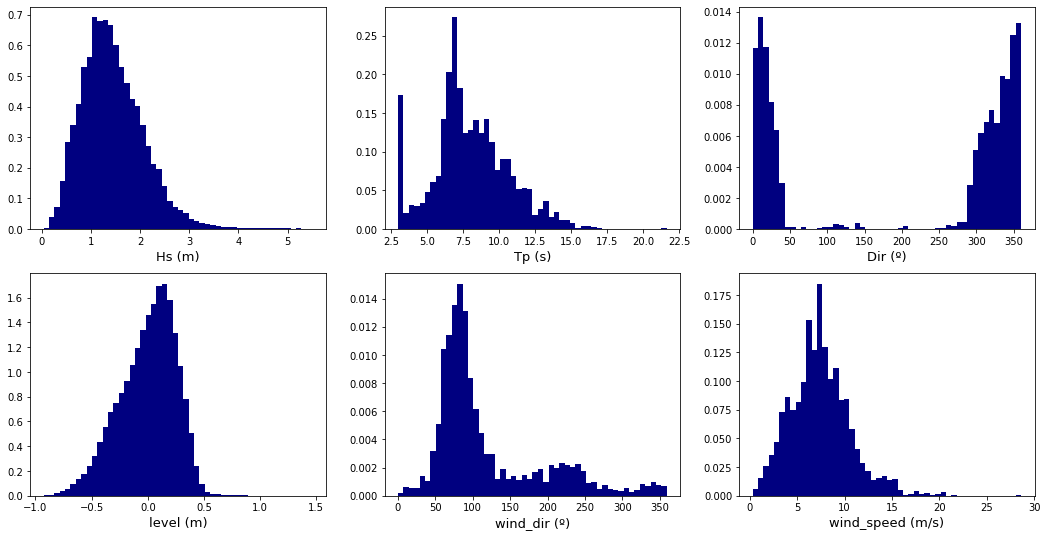

In [11]:
fig=plt.figure(figsize=[18,9])
vars=['Hs','Tp','Dir','level','wind_dir','wind_speed']
units=[' (m)',' (s)',' (º)',' (m)',' (º)',' (m/s)']

gs1=gridspec.GridSpec(2,3)

for a in range(len(vars)):
    ax=fig.add_subplot(gs1[a])
    ax.hist(SIM[vars[a]][:np.int(len(SIM)/100)],50,density=True,color='navy') #Plot a small fraction of data
    ax.set_xlabel(vars[a] + units[a],fontsize=13)

## **1. Clustering and selection method MDA**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black; text-align: justify">
The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v1}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.  

    
The MDA will be applied to 2 data sets, on the one hand, to the aggregated spectrum parameters and on the other hand to the spectrum partitions, differentiating seas and swells. In this way, the wind sea will have two added dimensions, wind speed and wind direction. 
<br>    
Representative variables for the different hydraulic boundary conditions:<br>
       <br>
(1) Waves                $H_{s}$, $T_p$<br>
(2) Wind                 $W_{x}$<br>

</span><br>

### **1.1 Data preproccesing**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black; text-align: justify">
    Select $H_{s}$, $T_p$, $W$, $W_{dir}$ from waves dataset and proyect wind velocity over the shore-cross profile (Wx). Unlike not being able to model the direction of the waves, Swash allows to model the wind direction. In order to reduce the MDA dimensions, working with the projected wind is desirable.
</span><br>

In [12]:
# Dataset 
# waves = waves.squeeze()
SIM = pd.DataFrame(
    {
        'time': SIM.time.values,
        'hs': SIM.Hs.values, 
        'tp': SIM.Tp.values, 
        'w':SIM.wind_speed.values,
        'wdir': SIM.wind_dir.values,
        'sl':SIM.level.values,
        'slr1':SIM.slr1.values,
        'slr2':SIM.slr2.values,
        'slr3':SIM.slr3.values
    }
)

In [13]:
#TEST WIND PROJECTION

In [14]:
# rel_beta=np.nanmin([np.abs(xds_states.wdir- profile.Orientation.values),np.abs(xds_states.wdir+360-profile.Orientation.values)],axis=0)
# rel_beta[np.where(rel_beta>=90)[0]]=np.nan
# rad_beta = (rel_beta*np.pi)/180
# xds_states['wx'] = xds_states.w.values*np.cos(rad_beta)

In [15]:
# #Test that wind projection is right
# pos_test=86281
# print('Orientation: ' + str(profile.Orientation.values))
# print('Wind speed: ' + str(xds_states.w[pos_test]))
# print('Wind dir: ' + str(xds_states.wdir[pos_test]))
# print('Beta relativo: ' + str(rel_beta[pos_test]))
# print('Wind proyected: ' + str(xds_states.wx[pos_test]))

In [16]:
# Proyect wind direction over bathymetry orientation

#Check wind is correctily projected
SIM = proy_wind(profile.Orientation.values, SIM)

In [17]:
SIM=SIM.drop(columns=['time', 'w', 'wdir']).dropna().reset_index()
SIM

,index,hs,tp,sl,slr1,slr2,slr3,wx
0,0,1.981425,7.297817,-0.197515,-0.007414,0.003706,0.020559,2.444419
1,1,1.995601,7.297817,-0.158739,-0.007414,0.003706,0.020560,2.444419
2,2,2.009776,7.297817,-0.088466,-0.007413,0.003706,0.020560,2.444419
3,3,2.023952,7.297817,-0.000945,-0.007413,0.003707,0.020560,2.444419
4,4,2.038127,7.297817,0.081685,-0.007412,0.003707,0.020561,2.444419
...,...,...,...,...,...,...,...,...
17531665,17531665,1.475372,8.624779,0.165252,0.414101,0.842310,1.309432,-5.739082
17531666,17531666,1.465686,8.624779,0.029800,0.414102,0.842312,1.309435,-5.739082
17531667,17531667,1.456001,8.624779,-0.138197,0.414102,0.842314,1.309439,-5.739082
17531668,17531668,1.446316,8.624779,-0.308221,0.414103,0.842315,1.309442,-5.739082


In [18]:
dataset = pd.DataFrame(
    {
        'hs': np.tile(SIM.hs,4),
        'tp': np.tile(SIM.tp,4), 
        'wx': np.tile(SIM.wx,4), 
        'level':np.concatenate((SIM.sl,SIM.slr1+SIM.sl,SIM.slr2+SIM.sl,SIM.slr3+SIM.sl))
    }
)

In [19]:
# dataset=np.column_stack((np.tile(SIM.hs,4),np.tile(SIM.tp,4),np.tile(SIM.wx,4),np.concatenate((SIM.sl,SIM.slr1+SIM.sl,SIM.slr2+SIM.sl,SIM.slr3+SIM.sl))))
# print(len(dataset))
# dataset

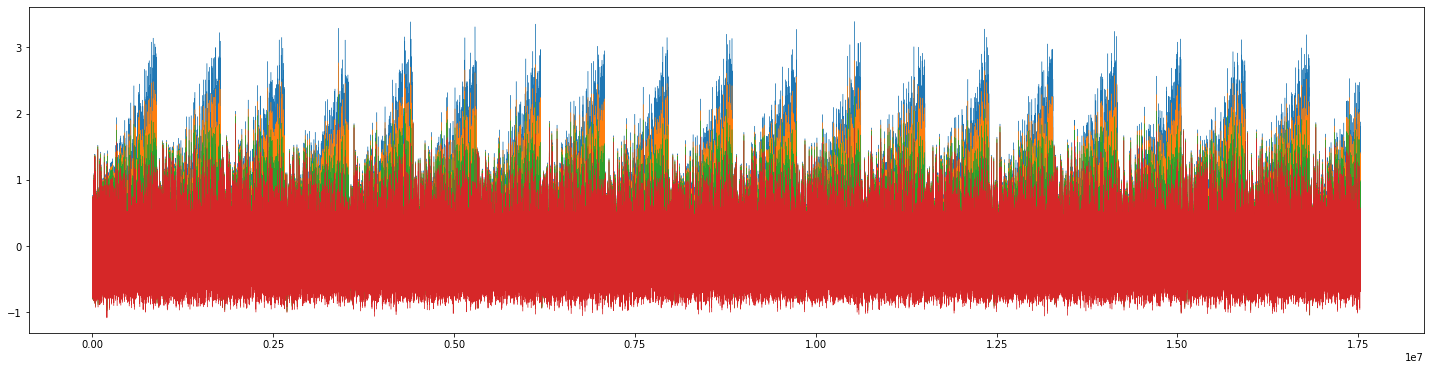

In [20]:
fig=plt.figure(figsize=[25,6])
gs1=gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs1[0])

ax.plot(SIM.slr3+SIM.sl,linewidth=0.4)
ax.plot(SIM.slr2+SIM.sl,linewidth=0.4)
ax.plot(SIM.slr1+SIM.sl,linewidth=0.4)
ax.plot(SIM.sl,linewidth=0.4)

### **1.2 MDA algorithm**

In [21]:
# dataset = SIM.drop(columns=['time', 'sl', 'w', 'wdir'])

# data = np.array(dataset.dropna())[:,:]

# subset, scalar and directional indexes
ix_scalar = [0, 1, 2, 3]      # hs, tp, wx, level
ix_directional = []        # 
n_subset = 1500      # subset size

# MDA algorithm
out = MaxDiss_Simplified_NoThreshold(
    np.array(dataset), 
    n_subset, 
    ix_scalar, ix_directional
)

subset = pd.DataFrame({'hs':out[:, 0],'tp':out[:, 1],'wx':out[:, 2],'level':out[:, 3]})

print(subset.info())

# store dataset and subset
SIM.to_pickle(p_dataset)
subset.to_pickle(p_subset)


MaxDiss waves parameters: 70126680 --> 1500

   MDA centroids: 1500/1500

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hs      1500 non-null   float64
 1   tp      1500 non-null   float64
 2   wx      1500 non-null   float64
 3   level   1500 non-null   float64
dtypes: float64(4)
memory usage: 47.0 KB
None


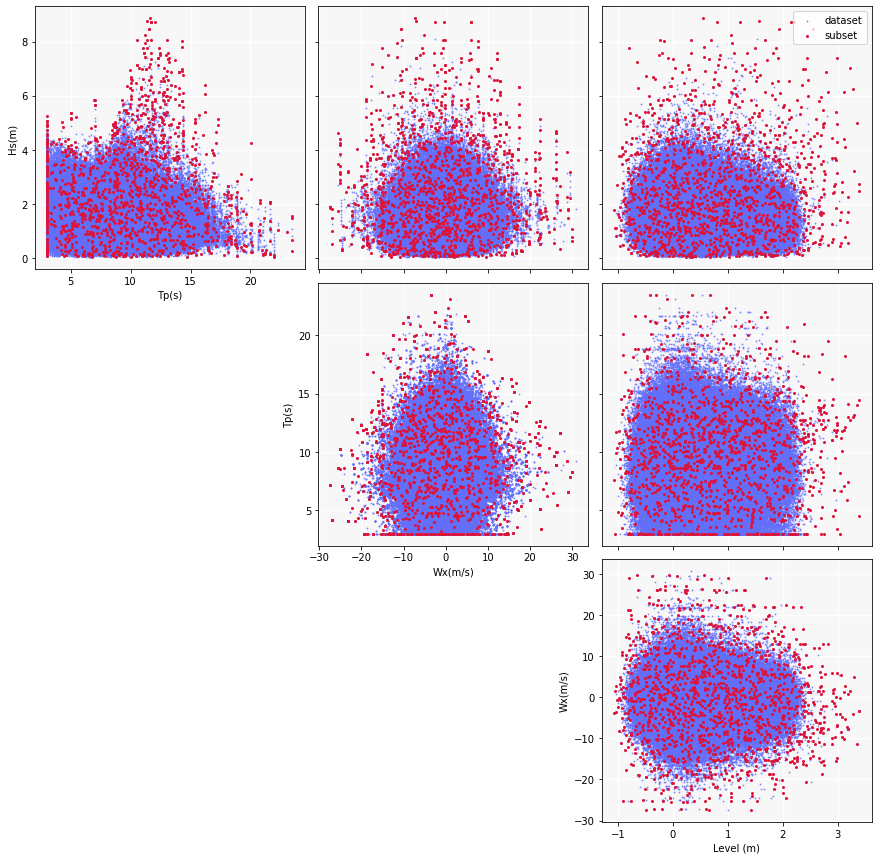

In [22]:
# Plot subset-dataset
fig = scatter_mda(dataset.loc[np.arange(1,len(dataset),100),:], subset, names = ['Hs(m)', 'Tp(s)', 'Wx(m/s)', 'Level (m)'], figsize=(15,15))
fig.savefig(op.join(p_out, 'mda_profile_'+str(prf)+'.png'),facecolor='w')

## **2. Numerical model SWASH**

### **2.1 Data preprocessing**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    In this section, the computational grid is defined from the bathymetric data and, optionally, wave dissipation characteristics due to the bottom friction or vegetation. The input grids will be considered uniform and rectangular, with the computational grid covering the whole bathymetric region. <br>

#### **2.1.1 Cross-shore profile**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Model boundaries should be far enough from the area of interest and away from steep topography to avoid unrealistic frictional or numerical dispersion effects but close enough to remain computationally feasible </span> <span style="font-family: times, Times New Roman; font-size:11pt; color:black; background:whitesmoke"> kh < 5. </span> </span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> As a recommendation, the area of interest should be kept at least two wave lengths away from the boundary. In the following cells, different input choices for defining the cross-shore profile will be given. </span>
 
* `dxL`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> : number of nodes per wavelength. This command sets the grid resolution from the number of nodes desired per wavelength in 1m depth (assuming that in the beach due to the infragravigity waves the water colum can reach 1m heigh). </span><br><br>

* `dxinp`: <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> The resolution of the bathymetric grid is not the same as that of the computational grid. It is advised to avoid extremely steep bottom slopes or sharp obstacles as much as posible. </span>  

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    Land points are defined as negative while wet points are defined as positive.
    </span>

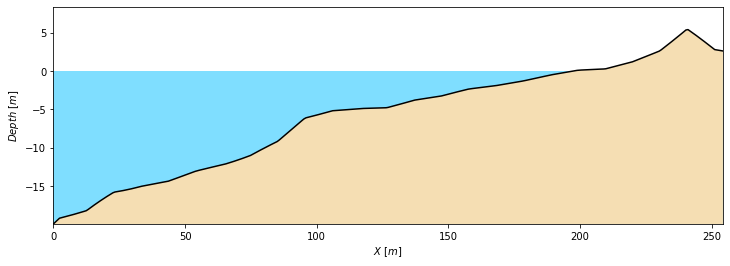

In [23]:
# Import depth FILE
sp.dxL = 30                                                                     # nº nodes per wavelength
sp.dxinp = np.abs(profile.Distance_profile.values[0]- profile.Distance_profile.values[1])                   
sp.depth=profile.Elevation.values

fig = sm.plot_depthfile()  

#### **2.1.2 Friction** 

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
With this option the user can activate the bottom friction controlled by the Manning formula. As the friction coefficient may vary over the computational region, the friction data can be read from file or defined by specifyng the start and end point along it is defined the frictional area (e.g. reef). 
    </p>

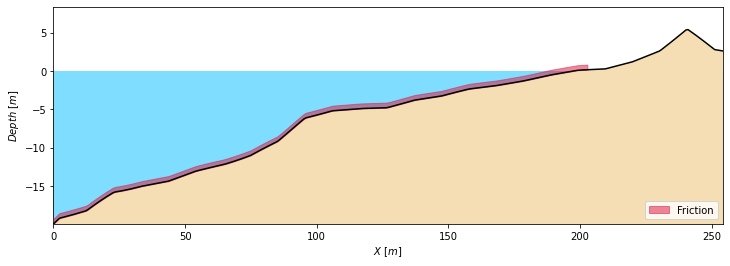

In [24]:
# Set a constant friction between two points of the profile 
sp.friction_file = False
sp.friction = True
sp.Cf = 0.02                       # manning frictional coefficient  (m^-1/3 s)
sp.cf_ini = 0                      # first point along the profile 
sp.cf_fin = sp.dxinp*np.where(profile.Elevation<0)[0][0]+5     # last point along the profile 
fig = sm.plot_depthfile()
plt.savefig(op.join(p_out, 'profile_'+str(prf)+'.png'),facecolor='w')

### **2.2 Boundary conditions**<br>
<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
    The boundaries of the computational grid in SWASH are either land, beach or water. The wave condition is imposed on the west boundary of the computational domain, so that the wave propagation is pointing eastward. To simulate entering waves without some reflections at the wavemaker boundary, a weakly-reflective boundary condition allowing outgoing waves is adopted. For this test case, a time series synthesized from parametric information (wave height, period, etc.) will be given as wavemaker. Here, the wavemaker must be defined as irregular unidirectional waves by means of 1D spectrum. Both the initial water level and velocity components are set to zero.
</p>

In [25]:
# Set the simulation period and grid resolution
sp.tendc = 3600                          # simulation period (SEC)
sp.warmup = 0.15 * sp.tendc              # spin-up time (s) (default 15%)

#### **2.2.1 Sea state**<br>

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;">
The input wave forcing is set as a 1D Jonswap spectrum with $\gamma$ parameter 3. As the water level is a deterministic variable, it can be included considering different disccrete values in the range of low-high tide.
</p> 

<p style="font-family: times, Times New Roman; font-size:12pt; font-style:italic; font-weight:bold; color:royalblue;">
Water level
</p> 

In [26]:
low_level = 0
high_level = 0
step = 0.5

wl = np.arange(low_level, high_level+step, step)    # water level (m)
print('Water levels: {0}'.format(wl))

Water levels: [0.]


In [27]:
subset

,hs,tp,wx,level
0,8.862897,11.641232,-7.267626,0.543520
1,0.103308,3.000000,13.875140,1.852032
2,0.254114,23.495678,-3.385635,-0.311708
3,1.868799,7.131098,-27.396780,-0.484634
4,3.668952,11.313573,21.241918,-0.808826
...,...,...,...,...
1495,0.067430,8.585007,5.600888,1.209101
1496,4.359310,3.000000,6.528602,1.075849
1497,1.752797,8.185738,-8.791575,0.685967
1498,1.623367,19.666843,-9.681165,0.166728


<p style="font-family: times, Times New Roman; font-size:12pt; font-style:italic; font-weight:bold; color:royalblue;">
Jonswap spectrum
</p>   

In [28]:
dir_wx = np.full([len(subset.wx)],0)
dir_wx = np.where(subset.wx<=0,180,0)
print(dir_wx)

[180   0 180 ... 180 180   0]


In [29]:
# Define JONSWAP spectrum by means of the following spectral parameters                                            

sp.gamma = 10
waves = pd.DataFrame(
            {
            "forcing": ['Jonswap'] * n_subset,
             "WL": subset.level,
             "Hs": subset.hs,
             "Tp": subset.tp,
             'Wx': np.abs(subset.wx),
             'Wdir': dir_wx,   
             "gamma": np.full([n_subset],sp.gamma),
             "warmup":  np.full([n_subset],sp.warmup)
            }
        )
waves

,forcing,WL,Hs,Tp,Wx,Wdir,gamma,warmup
0,Jonswap,0.543520,8.862897,11.641232,7.267626,180,10,540.0
1,Jonswap,1.852032,0.103308,3.000000,13.875140,0,10,540.0
2,Jonswap,-0.311708,0.254114,23.495678,3.385635,180,10,540.0
3,Jonswap,-0.484634,1.868799,7.131098,27.396780,180,10,540.0
4,Jonswap,-0.808826,3.668952,11.313573,21.241918,0,10,540.0
...,...,...,...,...,...,...,...,...
1495,Jonswap,1.209101,0.067430,8.585007,5.600888,0,10,540.0
1496,Jonswap,1.075849,4.359310,3.000000,6.528602,0,10,540.0
1497,Jonswap,0.685967,1.752797,8.185738,8.791575,180,10,540.0
1498,Jonswap,0.166728,1.623367,19.666843,9.681165,180,10,540.0


In [30]:
# Create wave series and save 'waves.bnd' file
sp.deltat = 0.5            # delta time over which the wave series is defined
series = sw.make_waves_series(waves)    

#### **2.2.2 Wind**

<p style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
The user can optionally specify wind speed, direction and wind drag assuming constant values in the domain. As the test case is using cartesian coordinates, please set the direction where the wind cames from.
</p>

In [31]:
# Define wind parameters
sp.wind = True
sp.Wdir = waves.Wdir            # wind direction at 10 m height (º)
sp.Vel = waves.Wx  # wind speed  at 10 m height (m/s)Distance_profileÇ
sp.Ca = 0.0026       # dimensionless coefficient (default 0.002)

### **2.3. Run**

<span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> 
In the following, a series of predefined options have been choosen: <br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;font-weight:bold; background:khaki;">Grid resolution</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> is determined through a number of points per wavelength criteria: Courant number for numerical stability, number of points per wavelength, and manual upper and lower limits for grid cell sizes.<br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">The default value for the maximun </span><span style="font-family: times, Times New Roman; font-size:12pt; color:black; background:khaki; font-weight:bold;">wave breaking steepness</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">parameter is $ \alpha = 0.6$<br></span>

* <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> For high, nonlinear waves, or wave interaction with structures with steep slopes (e.g. jetties, quays), a Courant number of 0.5 is advised. Here, a dynamically adjusted </span><span style="font-family: times, Times New Roman;  color:black; font-size:12pt; background:khaki; font-weight:bold;">time step</span> <span style="font-family: times, Times New Roman; font-size:12pt; color:black;"> controlled by a Courant number range of (0.1 - 0.5) is implemented<br></span>


<span style="font-family: times, Times New Roman; font-size:12pt; color:black;">
User parametes:<br></span>

* `Nonhydrostatic`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">to include the non-hydrostatic pressure in the shallow water equations. Hydrostatic pressure assumption can be made in case of propagation of long waves, such as large-scale ocean circulations, tides and storm surges. This assumption does not hold in case of propagation of short waves, flows over a steep bottom, unstable stratified flows, and other small-scale applications where vertical acceleration is dominant </span>
* `vert`  <span style="font-family: times, Times New Roman; font-size:12pt; color:black;">this command set the number of vertical layers in case that the run will be in multi-layered mode </span><br><br>


In [32]:
# Create swash wrap 
sp.Nonhydrostatic = True               # True or False
sp.vert = 1                                       # vertical layers
sp.delttbl = 1                                   # time between output fields (s)

sw = SwashWrap(sp)
waves = sw.build_cases(waves)
waves.to_pickle(p_waves)

In [33]:
# Run cases
sw.run_cases()

SWASH CASE: 0000 SOLVED
SWASH CASE: 0001 SOLVED
SWASH CASE: 0002 SOLVED
SWASH CASE: 0003 SOLVED
SWASH CASE: 0004 SOLVED
SWASH CASE: 0005 SOLVED
SWASH CASE: 0006 SOLVED
SWASH CASE: 0007 SOLVED
SWASH CASE: 0008 SOLVED
SWASH CASE: 0009 SOLVED
SWASH CASE: 0010 SOLVED
SWASH CASE: 0011 SOLVED
SWASH CASE: 0012 SOLVED
SWASH CASE: 0013 SOLVED
SWASH CASE: 0014 SOLVED
SWASH CASE: 0015 SOLVED
SWASH CASE: 0016 SOLVED
SWASH CASE: 0017 SOLVED
SWASH CASE: 0018 SOLVED
SWASH CASE: 0019 SOLVED
SWASH CASE: 0020 SOLVED
SWASH CASE: 0021 SOLVED
SWASH CASE: 0022 SOLVED
SWASH CASE: 0023 SOLVED
SWASH CASE: 0024 SOLVED
SWASH CASE: 0025 SOLVED
SWASH CASE: 0026 SOLVED
SWASH CASE: 0027 SOLVED
SWASH CASE: 0028 SOLVED
SWASH CASE: 0029 SOLVED
SWASH CASE: 0030 SOLVED
SWASH CASE: 0031 SOLVED
SWASH CASE: 0032 SOLVED
SWASH CASE: 0033 SOLVED
SWASH CASE: 0034 SOLVED
SWASH CASE: 0035 SOLVED
SWASH CASE: 0036 SOLVED
SWASH CASE: 0037 SOLVED
SWASH CASE: 0038 SOLVED
SWASH CASE: 0039 SOLVED
SWASH CASE: 0040 SOLVED
SWASH CASE: 0041

KeyboardInterrupt: 

In [ ]:
## TARGET: Extract output from files
#do_extract=1
#if do_extract==1:
#    target = sw.metaoutput(waves)
#    target = target.rename({'dim_0': 'case'})
#    print(target)
#    target.to_netcdf(op.join(p_out, 'xds_out_prf'+str(prf)+'.nc'))
#else:
#    target = xr.open_dataset(op.join(p_out, 'xds_out_prf'+str(prf)+'.nc'))
#df_target = pd.DataFrame({'ru2':target.Ru2.values, 'q': target.q.values}) 
#print(df_target)

In [ ]:
#df_dataset=subset
#df_dataset['Ru2']=target.Ru2.values
#df_dataset['q']=target.q.values
#print(df_dataset)